# Univariate ARIMA Modeling of Cambodia Inflation Rate

## Objective
This notebook focuses on modeling and forecasting Cambodia’s inflation rate using
univariate time series methods (ARIMA).

Exploratory Data Analysis (EDA), stationarity diagnostics, and multivariate feature
selection were conducted separately and are summarized in `EDA_SUMMARY.md`.
Based on those findings, the Year-over-Year (YoY) inflation rate is selected as the
target variable for modeling.

The purpose of this notebook is:
- To identify an appropriate ARIMA model for inflation
- To validate the model using residual diagnostics
- To generate short-term inflation forecasts


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.style.use("seaborn-v0_8")

In [2]:
df = pd.read_csv("data/processed_inflation_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

inflation = df["YoY_Change_CPI_all_item"]
inflation.head()

Date
2005-01-22    5.12
2005-02-22    5.35
2005-03-22    5.09
2005-04-22    6.15
2005-05-22    6.67
Name: YoY_Change_CPI_all_item, dtype: float64

## Inflation Time Series Overview

A brief visualization is presented to contextualize the inflation dynamics.
Detailed exploratory analysis is omitted here, as it was completed in the EDA phase.


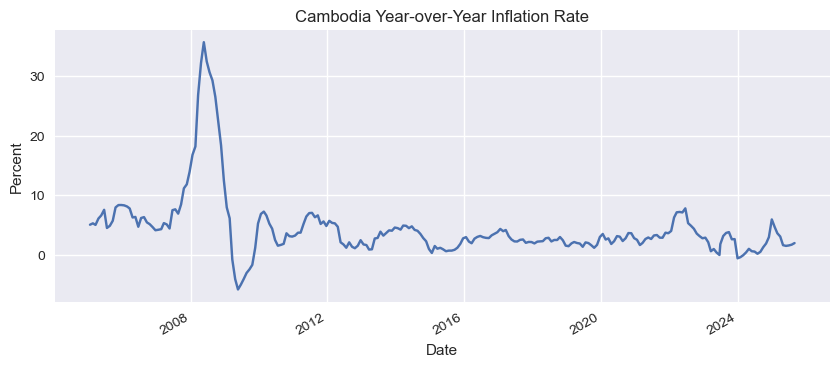

In [3]:
inflation.plot(figsize=(10,4))
plt.title("Cambodia Year-over-Year Inflation Rate")
plt.ylabel("Percent")
plt.show()

## Stationarity Test

To determine the appropriate differencing order (d), the Augmented Dickey–Fuller (ADF)
test is applied to the inflation series.


In [4]:
adf_result = adfuller(inflation.dropna())

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -3.0808218252084054
p-value: 0.028005399726343607


At the 5% significance level, the null hypothesis of a unit root is rejected.
Therefore, the inflation series is stationary and no differencing is required
(d = 0).

## Model Identification using ACF and PACF

Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots are used to identify
candidate ARIMA(p,d,q) models.

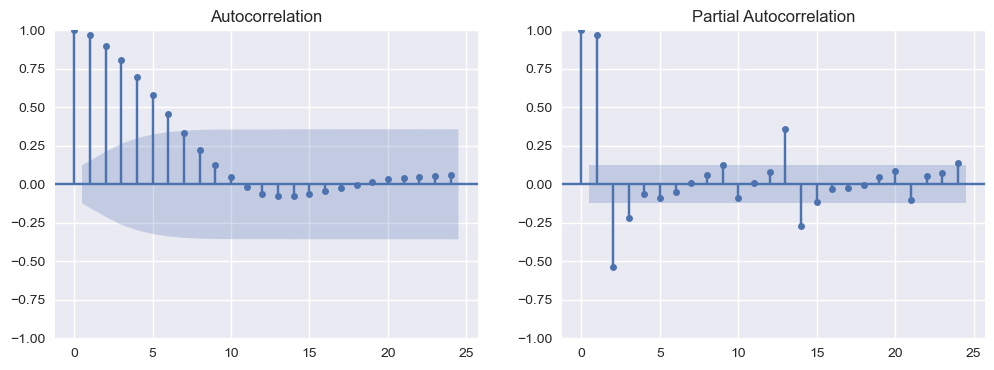

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(inflation.dropna(), ax=axes[0], lags=24)
plot_pacf(inflation.dropna(), ax=axes[1], lags=24, method="ywm")
plt.show()

This pattern is characteristic of an autoregressive process of order one.
Therefore, an ARIMA(2,0,0) model is selected as the primary candidate for
estimation.

## ARIMA Model Estimation

Several candidate ARIMA models are estimated and compared using AIC.


In [6]:
model_ar2 = ARIMA(inflation, order=(2,0,0))
result_ar2 = model_ar2.fit()
print(result_ar2.summary())

                                  SARIMAX Results                                  
Dep. Variable:     YoY_Change_CPI_all_item   No. Observations:                  249
Model:                      ARIMA(2, 0, 0)   Log Likelihood                -394.602
Date:                     Sun, 04 Jan 2026   AIC                            797.204
Time:                             18:56:07   BIC                            811.273
Sample:                                  0   HQIC                           802.867
                                     - 249                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3861      1.689      2.596      0.009       1.075       7.697
ar.L1          1.4874      0.041     36.681      0.000       1.408       1.567
ar.L2       

c:\Users\limse\miniconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\limse\miniconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\limse\miniconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [7]:
model_arma = ARIMA(inflation, order=(2,0,1))
result_arma = model_arma.fit()

print("ARIMA(2,0,0) AIC:", result_ar2.aic)
print("ARIMA(2,0,1) AIC:", result_arma.aic)


ARIMA(2,0,0) AIC: 797.2036033205079
ARIMA(2,0,1) AIC: 784.5714656744798


c:\Users\limse\miniconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\limse\miniconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\limse\miniconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Based on the ACF and PACF patterns, an ARIMA(1,0,0) model was initially estimated.
While the autoregressive coefficient was highly significant, diagnostic tests
revealed significant residual autocorrelation (Ljung–Box p < 0.05), indicating
that the model did not fully capture the dynamics of the series.

An ARIMA(2,0,1) model was subsequently estimated to account for short-term shock
effects. This specification resulted in a substantial improvement in model fit,
with the AIC decreasing from 797.20 to 784.57.

Therefore, the ARIMA(2,0,1) model was selected as the final specification.

In [8]:
model_final = ARIMA(inflation, order=(2,0,1))
result_final = model_final.fit()
print(result_final.summary())


                                  SARIMAX Results                                  
Dep. Variable:     YoY_Change_CPI_all_item   No. Observations:                  249
Model:                      ARIMA(2, 0, 1)   Log Likelihood                -387.286
Date:                     Sun, 04 Jan 2026   AIC                            784.571
Time:                             18:56:07   BIC                            802.159
Sample:                                  0   HQIC                           791.651
                                     - 249                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4136      1.220      3.618      0.000       2.023       6.805
ar.L1          1.7726      0.034     51.467      0.000       1.705       1.840
ar.L2       

c:\Users\limse\miniconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\limse\miniconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\limse\miniconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Among the candidate specifications, the ARIMA(2,0,1) model achieved the lowest AIC
value (784.57), representing a substantial improvement over simpler alternatives.
All estimated coefficients are highly statistically significant.

Residual diagnostics confirm the adequacy of the model. The Ljung–Box test fails to
reject the null hypothesis of no residual autocorrelation (p = 0.90), indicating
that the serial dependence in the inflation series has been effectively captured.
While the residuals deviate from normality and exhibit heteroskedasticity, these
features are commonly observed in macroeconomic inflation data and do not invalidate
the model.

Therefore, the ARIMA(2,0,1) specification is selected as the final univariate model
for Cambodia’s inflation rate.

## Economic Interpretation

The estimated dynamics suggest that Cambodia’s inflation exhibits strong short-term
persistence combined with a corrective mechanism over a two-month horizon. Positive
inflation shocks tend to persist initially but are partially offset in subsequent
periods, leading to mean-reverting behavior.

## Inflation Forecast

The validated ARIMA model is used to generate forecasts for future inflation.


In [10]:
forecast = result_final.get_forecast(steps=12)
ci = forecast.conf_int()

forecast_df = forecast.summary_frame()
forecast_df

c:\Users\limse\miniconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\limse\miniconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


YoY_Change_CPI_all_item,mean,mean_se,mean_ci_lower,mean_ci_upper
249,2.343314,1.137971,0.112931,4.573697
250,2.660633,1.904291,-1.071710,6.392975
251,2.992374,2.606494,-2.116261,8.101009
252,3.321987,3.232133,-3.012877,9.656850
253,3.636081,3.768836,-3.750702,11.022863
254,3.924399,4.211474,-4.329938,12.178737
255,4.179668,4.561689,-4.761079,13.120415
256,4.397345,4.826401,-5.062226,13.856916
257,4.575302,5.016207,-5.256283,14.406888
258,4.713469,5.143883,-5.368355,14.795294


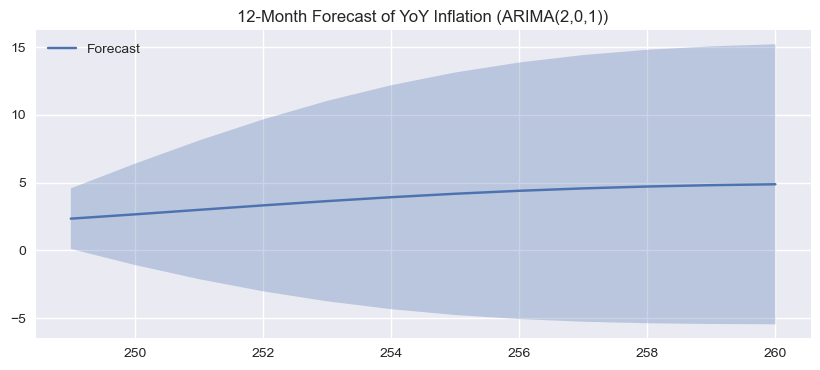

In [11]:
forecast.predicted_mean.plot(figsize=(10,4), label="Forecast")
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.3)
plt.legend()
plt.title("12-Month Forecast of YoY Inflation (ARIMA(2,0,1))")
plt.show()


## Forecast Results and Interpretation

The ARIMA(2,0,1) model forecasts a gradual increase in Cambodia’s year-over-year
inflation over the next 12 months. The point forecast rises from approximately
2.3% in the near term to around 4.9% by the end of the forecast horizon.

Confidence intervals widen as the forecast horizon increases, reflecting growing
uncertainty in inflation dynamics. While short-term forecasts are relatively
precise, longer-term projections are sensitive to potential economic shocks,
policy interventions, and external influences.

Negative lower bounds in the confidence intervals reflect statistical uncertainty
rather than a central deflation forecast.
